# Cliff walking

In [1]:
#######################################################################
# Copyright (C)                                                       #
# 2016-2018 Shangtong Zhang(zhangshangtong.cpp@gmail.com)             #
# 2016 Kenta Shimada(hyperkentakun@gmail.com)                         #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# world height
WORLD_HEIGHT = 4

# world width
WORLD_WIDTH = 12

# probability for exploration
EPSILON = 0.1

# step size
ALPHA = 0.5

# gamma for Q-Learning and Expected Sarsa
GAMMA = 1

# all possible actions
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]

# initial state action pair values
START = [3, 0]
GOAL = [3, 11]

In [3]:
def step(state, action):
    i, j = state
    if action == ACTION_UP:
        next_state = [max(i - 1, 0), j]
    elif action == ACTION_LEFT:
        next_state = [i, max(j - 1, 0)]
    elif action == ACTION_RIGHT:
        next_state = [i, min(j + 1, WORLD_WIDTH - 1)]
    elif action == ACTION_DOWN:
        next_state = [min(i + 1, WORLD_HEIGHT - 1), j]
    else:
        assert False

    reward = -1
    if (action == ACTION_DOWN and i == 2 and 1 <= j <= 10) or (
        action == ACTION_RIGHT and state == START):
        reward = -100
        next_state = START

    return next_state, reward

def choose_action(state, q_value):
    if np.random.binomial(1, EPSILON) == 1:
        return np.random.choice(ACTIONS)
    else:
        values_ = q_value[state[0], state[1], :]
        return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

def print_optimal_policy(q_value):
    optimal_policy = []
    for i in range(0, WORLD_HEIGHT):
        optimal_policy.append([])
        for j in range(0, WORLD_WIDTH):
            if [i, j] == GOAL:
                optimal_policy[-1].append('G')
                continue
            bestAction = np.argmax(q_value[i, j, :])
            if bestAction == ACTION_UP:
                optimal_policy[-1].append('U')
            elif bestAction == ACTION_DOWN:
                optimal_policy[-1].append('D')
            elif bestAction == ACTION_LEFT:
                optimal_policy[-1].append('L')
            elif bestAction == ACTION_RIGHT:
                optimal_policy[-1].append('R')
    for row in optimal_policy:
        print(row)

In [4]:

# an episode with Sarsa
# @q_value: values for state action pair, will be updated
# @expected: if True, will use expected Sarsa algorithm
# @step_size: step size for updating
# @return: total rewards within this episode
def sarsa(q_value, expected=False, step_size=ALPHA):
    state = START
    action = choose_action(state, q_value)
    rewards = 0.0
    while state != GOAL:
        next_state, reward = step(state, action)
        next_action = choose_action(next_state, q_value)
        rewards += reward
        if not expected:
            target = q_value[next_state[0], next_state[1], next_action]
        else:
            # calculate the expected value of new state
            target = 0.0
            q_next = q_value[next_state[0], next_state[1], :]
            best_actions = np.argwhere(q_next == np.max(q_next))
            for action_ in ACTIONS:
                if action_ in best_actions:
                    target += ((1.0 - EPSILON) / len(best_actions) + EPSILON / len(ACTIONS)) * q_value[next_state[0], next_state[1], action_]
                else:
                    target += EPSILON / len(ACTIONS) * q_value[next_state[0], next_state[1], action_]
        target *= GAMMA
        q_value[state[0], state[1], action] += step_size * (
                reward + target - q_value[state[0], state[1], action])
        state = next_state
        action = next_action
    return rewards

# an episode with Q-Learning
# @q_value: values for state action pair, will be updated
# @step_size: step size for updating
# @return: total rewards within this episode
def q_learning(q_value, step_size=ALPHA):
    state = START
    rewards = 0.0
    while state != GOAL:
        action = choose_action(state, q_value)
        next_state, reward = step(state, action)
        rewards += reward
        # Q-Learning update
        q_value[state[0], state[1], action] += step_size * (
                reward + GAMMA * np.max(q_value[next_state[0], next_state[1], :]) -
                q_value[state[0], state[1], action])
        state = next_state
    return rewards


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.05s/it]


Sarsa Optimal Policy:
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'R', 'U', 'D', 'R', 'U', 'U', 'U', 'R', 'U', 'R', 'D']
['U', 'U', 'R', 'L', 'L', 'U', 'U', 'L', 'U', 'U', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']
Q-Learning Optimal Policy:
['D', 'D', 'R', 'R', 'R', 'D', 'U', 'D', 'U', 'R', 'R', 'D']
['U', 'R', 'D', 'R', 'R', 'R', 'D', 'D', 'R', 'D', 'D', 'D']
['R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'D']
['U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'U', 'G']


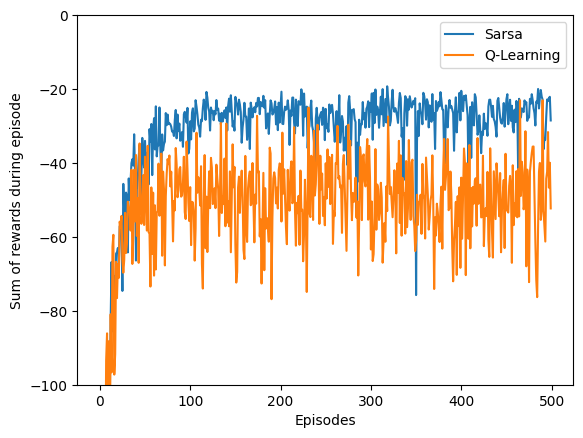

In [5]:
# Use multiple runs instead of a single run and a sliding window
# With a single run I failed to present a smooth curve
# However the optimal policy converges well with a single run
# Sarsa converges to the safe path, while Q-Learning converges to the optimal path
def figure_6_4():
    # episodes of each run
    episodes = 500

    # perform 40 independent runs
    runs = 50

    rewards_sarsa = np.zeros(episodes)
    rewards_q_learning = np.zeros(episodes)
    for r in tqdm(range(runs)):
        q_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
        q_q_learning = np.copy(q_sarsa)
        for i in range(0, episodes):
            # cut off the value by -100 to draw the figure more elegantly
            # rewards_sarsa[i] += max(sarsa(q_sarsa), -100)
            # rewards_q_learning[i] += max(q_learning(q_q_learning), -100)
            rewards_sarsa[i] += sarsa(q_sarsa)
            rewards_q_learning[i] += q_learning(q_q_learning)

    # averaging over independt runs
    rewards_sarsa /= runs
    rewards_q_learning /= runs

    # draw reward curves
    plt.plot(rewards_sarsa, label='Sarsa')
    plt.plot(rewards_q_learning, label='Q-Learning')
    plt.xlabel('Episodes')
    plt.ylabel('Sum of rewards during episode')
    plt.ylim([-100, 0])
    plt.legend()

    plt.plot()

    # display optimal policy
    print('Sarsa Optimal Policy:')
    print_optimal_policy(q_sarsa)
    print('Q-Learning Optimal Policy:')
    print_optimal_policy(q_q_learning)

figure_6_4()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:42<00:00,  4.29s/it]


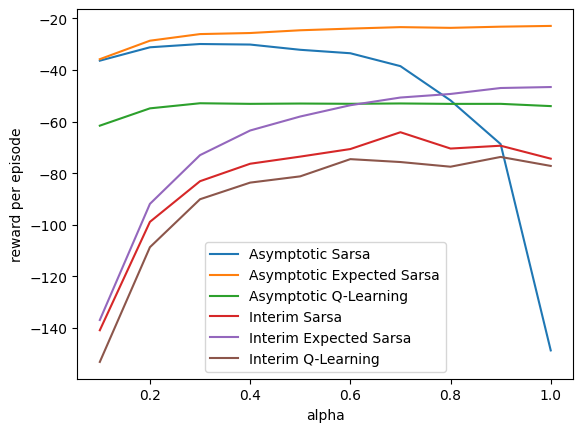

In [6]:
# Due to limited capacity of calculation of my machine, I can't complete this experiment
# with 100,000 episodes and 50,000 runs to get the fully averaged performance
# However even I only play for 1,000 episodes and 10 runs, the curves looks still good.
def figure_6_6():
    step_sizes = np.arange(0.1, 1.1, 0.1)
    episodes = 1000
    runs = 10

    ASY_SARSA = 0
    ASY_EXPECTED_SARSA = 1
    ASY_QLEARNING = 2
    INT_SARSA = 3
    INT_EXPECTED_SARSA = 4
    INT_QLEARNING = 5
    methods = range(0, 6)

    performace = np.zeros((6, len(step_sizes)))
    for run in range(runs):
        for ind, step_size in tqdm(list(zip(range(0, len(step_sizes)), step_sizes))):
            q_sarsa = np.zeros((WORLD_HEIGHT, WORLD_WIDTH, 4))
            q_expected_sarsa = np.copy(q_sarsa)
            q_q_learning = np.copy(q_sarsa)
            for ep in range(episodes):
                sarsa_reward = sarsa(q_sarsa, expected=False, step_size=step_size)
                expected_sarsa_reward = sarsa(q_expected_sarsa, expected=True, step_size=step_size)
                q_learning_reward = q_learning(q_q_learning, step_size=step_size)
                performace[ASY_SARSA, ind] += sarsa_reward
                performace[ASY_EXPECTED_SARSA, ind] += expected_sarsa_reward
                performace[ASY_QLEARNING, ind] += q_learning_reward

                if ep < 100:
                    performace[INT_SARSA, ind] += sarsa_reward
                    performace[INT_EXPECTED_SARSA, ind] += expected_sarsa_reward
                    performace[INT_QLEARNING, ind] += q_learning_reward

    performace[:3, :] /= episodes * runs
    performace[3:, :] /= 100 * runs
    labels = ['Asymptotic Sarsa', 'Asymptotic Expected Sarsa', 'Asymptotic Q-Learning',
              'Interim Sarsa', 'Interim Expected Sarsa', 'Interim Q-Learning']

    for method, label in zip(methods, labels):
        plt.plot(step_sizes, performace[method, :], label=label)
    plt.xlabel('alpha')
    plt.ylabel('reward per episode')
    plt.legend()

    plt.plot()

figure_6_6()